# Using SciServer to work with data from the AstroPath&trade; Collaboration

### In this example notebook we'll show:
1. What AstroPath&trade; is and does
1. Exactly what data we've made available to MedHacks participants
1. How to query the available SQL database through CasJobs
1. How to read and work with the image data available on SciServer

You can use this notebook as a reference for any of the above as you work on your hacks : )

In [2]:
#imports
import sys, pathlib, subprocess, pandas, tifffile
import numpy as np, matplotlib.pyplot as plt, geopandas as gpd
from shapely import wkt
import SciServer.CasJobs as cj

In [1]:
%pip install imagecodecs

     |████████████████████████████████| 31.0 MB 19 kB/s s eta 0:00:01     | 2.1 MB 10.0 MB/s eta 0:00:03ta 0:00:03     |█████████▍                      | 9.1 MB 10.0 MB/s eta 0:00:03    |██████████▌                     | 10.2 MB 10.0 MB/s eta 0:00:03  | 17.5 MB 10.0 MB/s eta 0:00:0222.4 MB 21.1 MB/s eta 0:00:01 | 25.5 MB 21.1 MB/s eta 0:00:01████████████████████████▏  | 28.3 MB 21.1 MB/s eta 0:00:01 MB 21.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
#may need to pip install imagecodecs
# subprocess.run([sys.executable, '-m', 'pip', 'install', 'imagecodecs'])
import imagecodecs

#tell pandas to display all columns by default
pandas.set_option('display.max_columns', None)

In [4]:
#constants
db_name = 'PM51_1' #name of the database that's available through CasJobs
slide_id = 'M51_1' #ID of the example slide that's available
tifffolder = pathlib.Path(f'/home/idies/workspace/AstroPathPublic/{slide_id}/tiff') #path to .tif image data

## AstroPath&trade; in general

- [Unique collaboration between IDIES scientists and clinicians and researchers at the JH School of Medicine](https://idies.jhu.edu/astropath/)
- Goal is to curate and analyze large sets of multispectral immunofluorescence (mIF) microscopy image data
- Apply "big data" expertise in the space of cancer pathology and immunology

![](./notebook_images/several_wsi_overviews.png)


- Tissue specimens multiply stained and imaged using a [Vectra 3.0 Microscope](https://www.akoyabio.com/phenoptics/mantra-vectra-instruments/vectra-3-0/)
- Whole slides are imaged as sets of "high-power field" (HPF) tiles
- Each HPF overlaps with its adjacent tiles by 20%
- Images collected are:
    - corrected for warping and illumination variation effects
    - processed using software from the microscope company (Akoya's "inForm") to identify and phenotype individual cells
    - aligned to one another and stitched into single "whole slide" images

- Slide, HPF and cell information are used to populate a SQL database
- Studies of cells and other components of the tumor microenvironment advance research in pathology and immunology ([DOI: 10.1126/science.aba2609](https://www.science.org/doi/10.1126/science.aba2609))
- High-resolution views of many whole slide images, along with their annotations, are available on the [CellView site](http://test.cellview.idies.jhu.edu/openlayers/vuejs/) (currently in development)

| whole slide | HPF tiles | 20% overlap | phenotyped cells |
| ----------- | --------- | ----------- | ---------------- |
| ![](./notebook_images/slide_tiling_1.png) | ![](./notebook_images/slide_tiling_2.png) | ![](./notebook_images/slide_tiling_3.png) | ![](./notebook_images/slide_tiling_4.png) |

![](./notebook_images/slide_tiling.gif)

## Data that are available to participants

1. The component .tif images for every HPF in a single slide (called "M51_1") showing a section of tissue from a patient with melanoma
1. A SQL database containing information about all the cells and HPFs in that slide
1. Access to the test [CellView site](http://test.cellview.idies.jhu.edu/openlayers/vuejs/) (The slide we're providing to you can be found under Project01 with the name M51_1)

## Using CellView with the SQL Database to find specific images

#### You can use the CellView webpage to browse the whole slide image

CellView will show you the coordinates of your mouse pointer (screenshot below). Let's use our mouse to find a particular cell, and then query the database to find the HPF with that cell in it.

![](./notebook_images/cellview_screenshot.png)

In [5]:
# example cell location
cx, cy = (45416, 19365)

In [6]:
# SQL query for retrieiving the HPF containing the example cell
sql=f"""
SELECT h.*                             -- return all the columns for the HPF table entry
  FROM samples s                       -- from the table with all the samples/slides (s)
  JOIN hpfall h                        -- JOINed to the HPF table, aliased as h
    ON h.sampleid=s.sampleid           -- choose HPF with the same sampleid as the sample
   AND {cx} BETWEEN h.mx1 AND h.mx2    -- AND restrict the HPF to fields containing the X coordinate of the cell
   AND {cy} BETWEEN h.my1 AND h.my2    -- AND restrict the HPF to fields containing the Y coordinate of the cell
 WHERE s.slideid='{slide_id}'          -- find the sample for the particular slide of interest
"""
# execute the SQL query in synchronous mode using CasJobs
# send it to the database of interest by specifying the 'context' parameter
# request that the function return a pandas DataFrame, 'pandas' is also the default format
hpfs=cj.executeQuery(sql=sql,context=db_name,format='pandas')    

# show the resulting DataFrame
hpfs

,hpfid,isGood,sampleid,field,px,py,gc,gx,gy,mx1,my1,mx2,my2,cx,cy,cov_xx,cov_xy,cov_yy,ncells,tstamp,fname
0,400756,0,40,756,44699.060458,18791.164333,1,24,21,44834.349216,18892.069584,45905.836076,19695.117731,51564,11000,0.051454,0.00092,0.065962,2402,1526726048,"M51_1_[51564,11000].im3"


**We can use the result of the above query to find the .tif file corresponding to the HPF containing the cell**

In [7]:
tiff_filename=hpfs.fname[0].replace('.im3','_component_data.tif')
print(f'component tiff filename = {tiff_filename}')

example_filepath = tifffolder/tiff_filename

component tiff filename = M51_1_[51564,11000]_component_data.tif


## Image format

**Images are stored as component tiffs with 9 "pages"**

In [8]:
with tifffile.TiffFile(example_filepath) as example_image : # open the image file using the tifffile library
    print(example_image)

TiffFile 'M51_1_[51564,110…mponent_data.tif'  42.80 MiB  qpi  9 Pages  2 Series


**Each "page" of the tiff is an array of values**

In [9]:
with tifffile.TiffFile(example_filepath) as example_image :
    for pn,page in enumerate(example_image.pages,start=1) : # iterate over all the pages
        page_array = page.asarray() #get the page as a numpy array
        print(f'page #{pn} array datatype={page_array.dtype}, dimensions={page_array.shape}')

page #1 array datatype=float32, dimensions=(1004, 1344)
page #2 array datatype=float32, dimensions=(1004, 1344)
page #3 array datatype=float32, dimensions=(1004, 1344)
page #4 array datatype=float32, dimensions=(1004, 1344)
page #5 array datatype=float32, dimensions=(1004, 1344)
page #6 array datatype=float32, dimensions=(1004, 1344)
page #7 array datatype=float32, dimensions=(1004, 1344)
page #8 array datatype=float32, dimensions=(1004, 1344)
page #9 array datatype=uint8, dimensions=(251, 336, 3)


**The last page in each image is a 3D array. It's a three-channel (RGB) array of uint8s that shows a scaled-down false color overview of all the layers together**

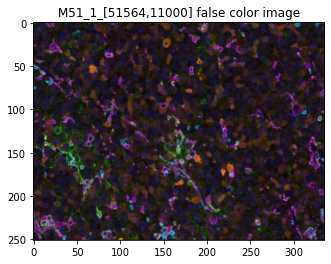

In [10]:
with tifffile.TiffFile(example_filepath) as example_image :
    color_image = example_image.pages[-1]
    plt.imshow(color_image.asarray())
    plt.title(f'{example_filepath.name.rstrip("_component_data.tif")} false color image')
    plt.show()

**All of the other pages show the same area of the slide, but they're imaged using different colors of filtered light. Each filter causes a specific stain to fluoresce, and each stain binds to a particular protein in the cells.**

**These other pages are 2D arrays of 32-bit floats**

In [11]:
# define a SQL query to get information about each of the stains from the database
sql_query = f"""
SELECT mc.*                   -- return all columns
  FROM samples s              -- from the table with all the samples (s)
  JOIN mergeconfig mc         -- JOINed to the table listing the filters used (mc)
    ON mc.batchid=s.batchid   -- where the batchid values match
 WHERE slideid = '{slide_id}' -- for the example slide
 ORDER BY layer               -- and put the results in order by image layer/page
"""
# execute the SQL query using CasJobs and get the result as a pandas dataframe
stain_info = cj.executeQuery(sql=sql_query, context=db_name, format='pandas') 
stain_info

,Project,Cohort,BatchID,layer,Opal,Target,Compartment,TargetType,CoexpressionStatus,SegmentationStatus,SegmentationHierarchy,NumberofSegmentations,ImageQA
0,1,1,6,1,DAPI,DNA,Nucleus,NA,NA,0,0,0,NA
1,1,1,6,2,520,PDL1,Membrane,Expression,"620,690",1,0,1,NA
2,1,1,6,3,540,CD8,Membrane,Lineage,570,1,1,1,Immune
3,1,1,6,4,570,FoxP3,Nucleus,Lineage,540,1,1,1,NA
4,1,1,6,5,620,Sox10/S100,Nucleus/Cyto,Lineage,NA,2,3,1,Tumor
5,1,1,6,6,650,PD1,Membrane,Expression,"540,570",1,0,1,NA
6,1,1,6,7,690,CD163,Membrane,Lineage,NA,1,2,1,NA
7,1,1,6,8,AF,NA,Nucleus,NA,NA,0,0,0,NA


page 1 shows the DAPI stain, which targets DNA in the Nucleus:


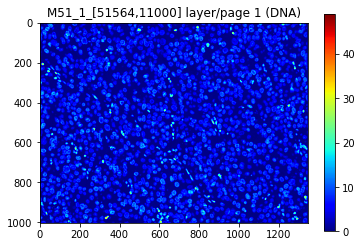

page 2 shows the 520 stain, which targets PDL1 in the Membrane:


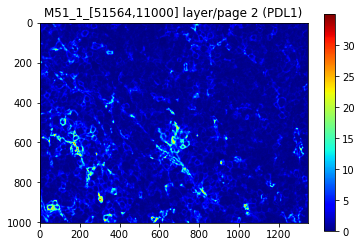

page 3 shows the 540 stain, which targets CD8 in the Membrane:


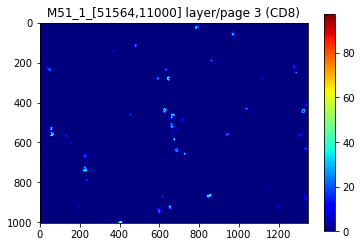

page 4 shows the 570 stain, which targets FoxP3 in the Nucleus:


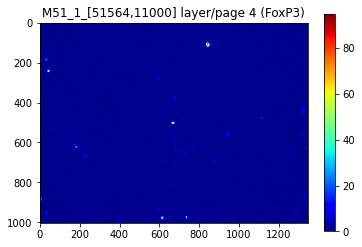

page 5 shows the 620 stain, which targets Sox10/S100 in the Nucleus/Cyto:


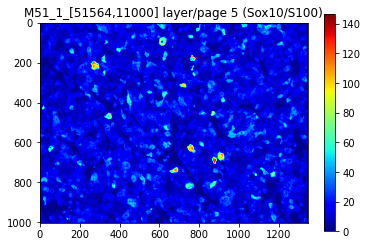

page 6 shows the 650 stain, which targets PD1 in the Membrane:


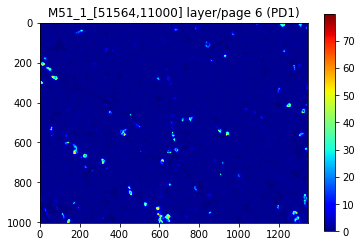

page 7 shows the 690 stain, which targets CD163 in the Membrane:


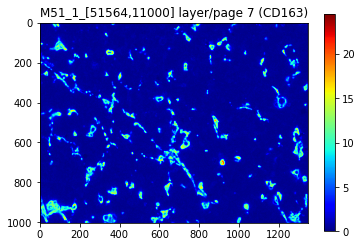

page 8 shows the AF stain, which targets NA in the Nucleus:


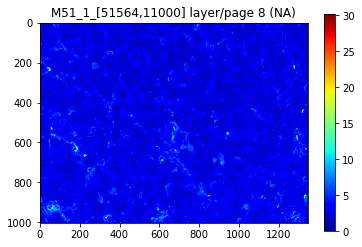

In [12]:
with tifffile.TiffFile(example_filepath) as example_image:
    #show each page of the image (except the last), with information about its stain
    for page, (pi, si) in zip(example_image.pages[:-1], stain_info.iterrows()):
        print(f'page {pi+1} shows the {si["Opal"]} stain, which targets {si["Target"]} in the {si["Compartment"]}:')
        f,ax = plt.subplots()
        pos = ax.imshow(page.asarray(),cmap='jet')
        f.colorbar(pos,ax=ax)
        ax.set_title(f'{example_filepath.name.rstrip("_component_data.tif")} layer/page {pi+1} ({si["Target"]})')
        plt.show()

**The 8th layer's name "AF" stands for "AutoFluorescence", which isn't a marker. Instead this layer shows anything that fluoresces relatively independently of which filter is used.**

## Comparing overlapping areas in adjacent HPFs 

**Let's find the HPF tile that is directly to the right of the image we showed above**

"Primary regions" of images only:
![](./notebook_images/adjacent_hpfs_primary.png)

Full images showing overlapping region:
![](./notebook_images/adjacent_hpfs_overlap.png)

In [13]:
# define a SQL query to return the example HPF and its neighbor to the right
sql_query=f'''
WITH hpf1 as (                         -- "hpf1" is the example HPF, found using the same query as above
SELECT h.*                             
  FROM samples s                       
  JOIN hpfall h                        
    ON h.sampleid=s.sampleid           
   AND {cx} BETWEEN h.mx1 AND h.mx2    
   AND {cy} BETWEEN h.my1 AND h.my2    
 WHERE s.slideid='{slide_id}'           
)
SELECT h.*                             -- return all columns
  FROM hpf1 h1                         -- from "hpf1" (aliased as "h1")
  JOIN hpfall h                        -- JOINed to the rest of the hpfs
    ON h.sampleid=h1.sampleid          -- with the same sampleid
   AND h.gx BETWEEN h1.gx AND h1.gx+1  -- restricted to HPFs with x position equal to the example or 1 greater
   AND h.gy = h1.gy                    -- AND restricted to HPFs with matching y positions
                                       -- (could use an interval for the y positions to get vertically adjacent HPFs)
'''
hpf_table=cj.executeQuery(sql_query,db_name)
hpf_table

,hpfid,isGood,sampleid,field,px,py,gc,gx,gy,mx1,my1,mx2,my2,cx,cy,cov_xx,cov_xy,cov_yy,ncells,tstamp,fname
0,400756,0,40,756,44699.060458,18791.164333,1,24,21,44834.349216,18892.069584,45905.836076,19695.117731,51564,11000,0.051454,0.000920,0.065962,2402,1526726048,"M51_1_[51564,11000].im3"
1,400757,0,40,757,45769.775772,18791.781438,1,25,21,45905.836076,18892.069584,46978.343489,19695.117731,52099,11000,0.052770,0.000491,0.067417,2296,1526726082,"M51_1_[52099,11000].im3"


**Use the image coordinates to find the corresponding component .tif files, and display the DAPI layers of both images**

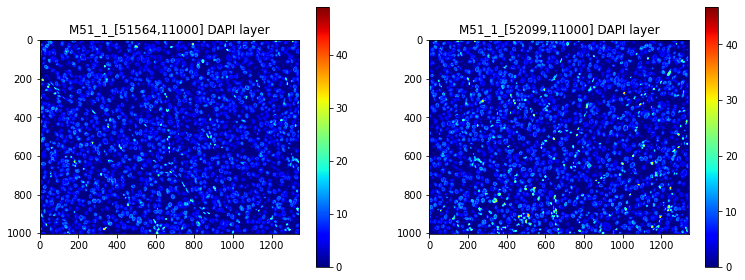

In [14]:
# find the coordinates of the HPFs to correlate them to their component .tif images
hpf_1 = hpf_table.iloc[0]
hpf_2 = hpf_table.iloc[1]
cx1, cy1 = hpf_1.cx, hpf_1.cy
cx2, cy2 = hpf_2.cx, hpf_2.cy
img_1_filename = f'{slide_id}_[{cx1},{cy1}]_component_data.tif'
img_2_filename = f'{slide_id}_[{cx2},{cy2}]_component_data.tif'

# get the DAPI layers of the two adjacent HPFs from their .tif files
with tifffile.TiffFile(tifffolder/img_1_filename) as tiff:
    img_1 = tiff.pages[0].asarray()
with tifffile.TiffFile(tifffolder/img_2_filename) as tiff:
    img_2 = tiff.pages[0].asarray()

# show the DAPI layers of the images
f,ax = plt.subplots(1,2,figsize=(2*6.4,6.4*(img_1.shape[0]/img_1.shape[1])))
pos = ax[0].imshow(img_1,cmap='jet')
f.colorbar(pos,ax=ax[0])
ax[0].set_title(f'{img_1_filename.rstrip("_component_data.tif")} DAPI layer')
pos = ax[1].imshow(img_2,cmap='jet')
f.colorbar(pos,ax=ax[1])
ax[1].set_title(f'{img_2_filename.rstrip("_component_data.tif")} DAPI layer')
plt.show()

**Use more information from the database query to find the overlapping region of the HPFs. We're converting to integers here for demonstration purposes, but we could be more precise by interpolating.**

In [15]:
# px, py = position of the top left corner of the HPF in the global coordinate system
px_1, py_1 = int(hpf_1["px"]), int(hpf_1["py"])
px_2, py_2 = int(hpf_2["px"]), int(hpf_2["py"])

# mx(1/2), my(1/2) = bounding box of the "primary region" of the HPF
# the area outside this region is not used and is instead taken from the duplicate
# image in the overlapping HPF
mx1_1, mx2_1, my1_1, my2_1 = int(hpf_1["mx1"]), int(hpf_1["mx2"]), int(hpf_1["my1"]), int(hpf_1["my2"])
mx1_2, mx2_2, my1_2, my2_2 = int(hpf_2["mx1"]), int(hpf_2["mx2"]), int(hpf_2["my1"]), int(hpf_2["my2"])

**We can plot the two HPFs in the same image, overlaid to show their overlapping region**

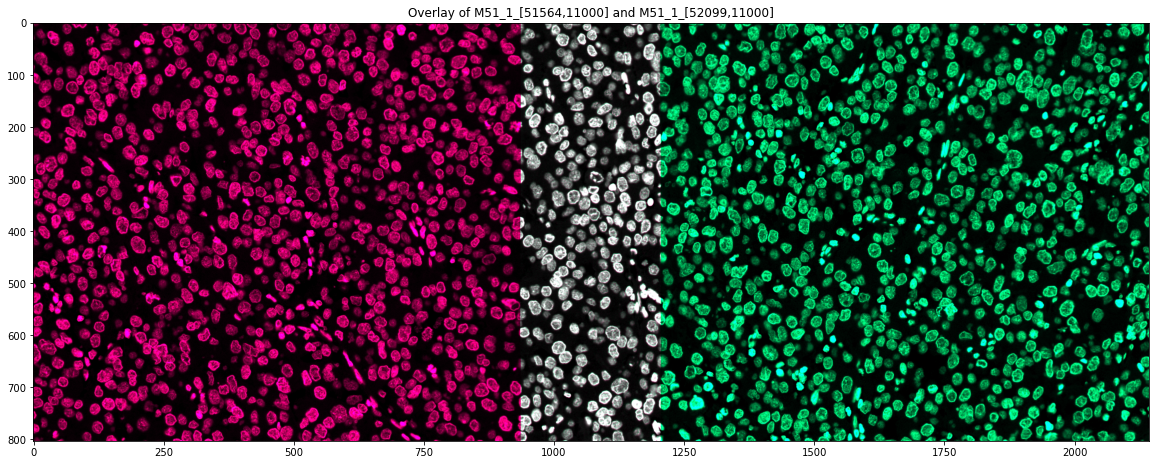

In [16]:
# limits of the overlay are the outer edges of both HPFs' primary regions
xmin, xmax = min(mx1_1, mx1_2), max(mx2_1, mx2_2)
ymin, ymax = min(my1_1, my1_2), max(my2_1, my2_2)

olap_width = mx1_1-px_1 # amount of width to add/subtract to show the overlapping region

# build the overlay image
red = np.zeros(shape=(ymax-ymin, xmax-xmin))
green = np.zeros(shape=(ymax-ymin, xmax-xmin))
red[my1_1-ymin:my2_1-ymin, mx1_1-xmin:mx2_1-xmin+olap_width] = img_1[my1_1-py_1:my2_1-py_1, mx1_1-px_1:mx2_1-px_1+olap_width]
green[my1_2-ymin:my2_2-ymin, mx1_2-xmin-olap_width:mx2_2-xmin] = img_2[my1_2-py_2:my2_2-py_2, mx1_2-px_2-olap_width:mx2_2-px_2]
norm = 0.25*np.max(np.array([red,green]))
red/=norm; green/=norm
overlay = np.clip(np.array([red,green,0.5*(red+green)]).transpose(1,2,0),0,1)

f=plt.figure(figsize=(20,10))
plt.imshow(overlay)
im1_name = img_1_filename.rstrip("_component_data.tif")
im2_name = img_2_filename.rstrip("_component_data.tif")
plt.title(f'Overlay of {im1_name} and {im2_name}')
plt.show()

## Finding all the cells in the two HPFs above

In [17]:
# define a SQL query to return all cells with locations within the two HPFs selected above
sql_query=f'''
SELECT g.*                             -- return all columns
  FROM cellall c                       -- from the table that contains all the cells (c)
  JOIN cellgeom g                      -- JOINed to the table containing information about their geometries (g)
    ON g.cellid=c.cellid               -- based on the ID of each cell
  WHERE c.px BETWEEN {xmin} AND {xmax} -- with results restricted to cells with x positions within the HPFs
    AND c.py BETWEEN {ymin} AND {ymax} -- and y positions also with the HPFs
'''
cells=cj.executeQuery(sql_query,db_name)
cells

,cellid,hpfid,tileindex,ptype,btype,geom
0,40075600013,400756,0,2,0,"POLYGON ((45340 19073, 45341 19072, 45342 1907..."
1,40075600013,400756,0,2,1,"POLYGON ((45343 19074, 45344 19073, 45345 1907..."
2,40075600014,400756,0,2,0,"POLYGON ((45320 19233, 45321 19232, 45321 1923..."
3,40075600014,400756,0,2,1,"POLYGON ((45321 19233, 45322 19232, 45322 1923..."
4,40075600016,400756,0,2,0,"POLYGON ((45355 19255, 45356 19254, 45357 1925..."
...,...,...,...,...,...,...
4320,40075702201,400757,0,0,1,"POLYGON ((46511 19343, 46512 19342, 46512 1934..."
4321,40075702202,400757,0,0,0,"POLYGON ((46471 19357, 46472 19356, 46473 1935..."
4322,40075702202,400757,0,0,1,"POLYGON ((46472 19357, 46473 19357, 46474 1935..."
4323,40075702294,400757,0,0,0,"POLYGON ((45908 19195, 45909 19194, 45910 1919..."


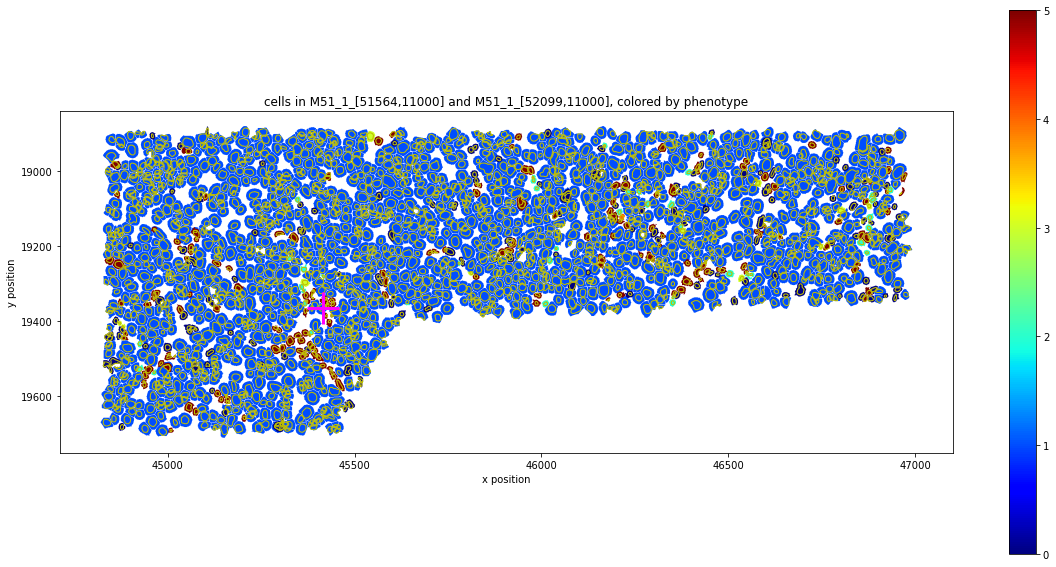

In [18]:
nuclei = cells[cells['btype']==1] # the table has entries for the entire cells (btype=0) and just the nuclei (btype=1)

# convert the polygon data table entries to geometric objects using shapely.wkt
cell_geometries = cells['geom'].apply(wkt.loads)
nucleus_geometries = nuclei['geom'].apply(wkt.loads)

# make GeoDataFrames from the table entries and their geometries
gcells=gpd.GeoDataFrame(cells, geometry=cell_geometries)
gnuclei=gpd.GeoDataFrame(nuclei, geometry=nucleus_geometries)

# plot the cells and nuclei
ax=gcells.plot(figsize=(20,10),column='ptype',legend=True,cmap='jet') #plot the cells, colored by phenotype
gnuclei.plot(ax=ax,facecolor='none',edgecolor='y') #plot the nuclei as yellow outlines
ax.scatter(cx,cy,s=1000, c='magenta', marker='+',linewidth=3) #plot the location of the original cell in magenta
ax.invert_yaxis()
title = f'cells in {img_1_filename.rstrip("_component_data.tif")} and '
title+= f'{img_2_filename.rstrip("_component_data.tif")}, colored by phenotype'
ax.set_title(title)
ax.set_xlabel('x position')
ax.set_ylabel('y position')
plt.show()